<center><h1>Using PCA for more efficient learning and for taking out noise from data</center></h1>
***


Here we will see will PCA helps to make better performance. PCA - Principal Component Analysis - helps to reduce dimensions of the dataset for efficient learning and also for eliminating the noice.

In [22]:
import pandas as pd
import sys
sys.path.append("../src")
from car_price_prediction.utils import dataset_manager, df_utils
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import r2_score

In [23]:
df = dataset_manager.get_processed_dataset()
X_train,X_test,y_train,y_test = df_utils.get_train_test(df,test_size=0.2)
X_train_ss, X_test_ss = df_utils.scale_train_test(X_train,X_test)
X_train_ssdum, X_test_ssdum = df_utils.make_dummies(X_train_ss,X_test_ss)

Below, you can see how function plotting the result of the training and cv tests, on quantity of pca components. This algorithm works few hours on desktop computer, so I will just load plot, from plot folder in src, if you need you can run it.

In [24]:
def get_pca_plot(X,y):
    param_range = np.arange(1,X.shape[1]+1,1)
    train_scores, cv_scores = get_pca_results(X,y)
    plt.title('Model Complexity curves')
    plt.plot(param_range, train_scores,label='Training score',lw = 2)
    plt.plot(param_range,cv_scores, label = 'CV score',lw = 2)
    plt.xlabel('Number of dimensions(components)')
    plt.ylabel('Mean absolute error')
    plt.legend()
    return plt
    
def get_pca_results(X,y):
    forest = RandomForestRegressor()
    train_scores = []
    cv_scores = []
    for dimension in range(1,X.shape[1]):
        pca = PCA(n_components=dimension) 
        X_pca = pca.fit_transform(X)
        forest.fit(X_pca,y)
        y_pred = forest.predict(X_pca)
        train_scores.append(mean_absolute_error(y,y_pred))
        cv_score = cross_val_score(forest, X_pca,y,cv = 5, scoring='neg_mean_absolute_error')
        cv_scores.append(abs(cv_score.mean()))
    return train_scores,cv_scores

Plot below shows the results of train and cv set on different dimensions starting with one. It shows us that the results start to be the same after 50th dimension.

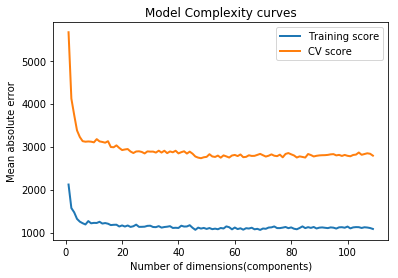

In [25]:
from IPython.display import Image
img = Image('../plots/model-complexity.png')
display(img)

Here, you can see the results of the algorithm showing how much of the variance remains after pca reduction

In [26]:
pca = PCA()
pca.fit(X_train_ssdum)
for dimension in range(X_train_ssdum.shape[1]):
    variance = pca.explained_variance_ratio_[:dimension].sum() * 100.0
    print("PCA with %d components retains: %.3f of variance" % (dimension,variance))

PCA with 0 components retains: 0.000 of variance
PCA with 1 components retains: 28.109 of variance
PCA with 2 components retains: 44.481 of variance
PCA with 3 components retains: 50.820 of variance
PCA with 4 components retains: 56.376 of variance
PCA with 5 components retains: 60.222 of variance
PCA with 6 components retains: 63.625 of variance
PCA with 7 components retains: 66.469 of variance
PCA with 8 components retains: 69.077 of variance
PCA with 9 components retains: 71.460 of variance
PCA with 10 components retains: 73.682 of variance
PCA with 11 components retains: 75.621 of variance
PCA with 12 components retains: 77.403 of variance
PCA with 13 components retains: 79.139 of variance
PCA with 14 components retains: 80.798 of variance
PCA with 15 components retains: 82.186 of variance
PCA with 16 components retains: 83.477 of variance
PCA with 17 components retains: 84.590 of variance
PCA with 18 components retains: 85.649 of variance
PCA with 19 components retains: 86.650 of 

We can see that 99 per cent of variance retains if we reduce dimensions to 53-54 components via PCA. Which is good, considering my algorithm works a little slow on server. And lastly I want to see performance on cross-validation of reduced data and usual data. And if accuracy remains approximately same or even gets better than without PCA (that happens when data is too noicy), I am going to use it

In [27]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
X_train_dum,X_test_dum = df_utils.make_dummies(X_train,X_test)
scores_without_pca = cross_val_score(forest,X_train_dum,y_train,scoring='neg_mean_absolute_error',cv=5)
print("Cross-Validation score on data without dimensionality reduction is %.3f" % scores_without_pca.mean())

Cross-Validation score on data without dimensionality reduction is -2321.598


In [28]:
forest_pca = RandomForestRegressor()
pca = PCA(n_components=54)
pca.fit(X_train_ssdum)
X_train_pca = pca.fit_transform(X_train_ssdum)
X_test_pca = pca.transform(X_test_ssdum)
scores_pca = cross_val_score(forest_pca,X_train_pca,y_train,scoring='neg_mean_absolute_error',cv=5)
print("Cross-Validation score on data with PCA with 54 components is %.3f" %scores_pca.mean())

Cross-Validation score on data with PCA with 54 components is -2634.624


And on the test set the  r2 score is as follows

In [29]:
forest.fit(X_train_dum,y_train)
y_test_pred = forest.predict(X_test_dum)
print(r2_score(y_test,y_test_pred))

0.9151188872013153


In [30]:
forest.fit(X_train_pca,y_train)
y_test_pred_pca = forest.predict(X_test_pca)
print(r2_score(y_test,y_test_pred_pca))

0.8831374561862407


I am losing my accuracy after PCA implementation. I think the reason is, car's price can be totally different depending on year, even one year difference may change price vastly. So, even after retaining 99 percent of information in dataset, I still lose accuracy, and for me accuracy is more important, than waiting time for a prediction.